In [5]:
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 20,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 20,
          'legend.fontsize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# Transfer functions

In [6]:
QE = 1.60217656535e-19
from scipy import integrate
from pycbc import cosmology
def integrand_parityaeff(redshift, parity_beta):
    """
    The integrand:
    (1.0 + z)^parity_beta / sqrt(Omega_m (1+z)^3 + Omega_Lambda)
    """
    omega_m = 0.3075 #pycbc.cosmology.get_cosmology().Om0 # matter density
    omega_l = 0.6910098821161554 #pycbc.cosmology.get_cosmology().Ode0 # dark energy density

    return (1.0+redshift)**(parity_beta)/ np.sqrt(omega_m*(1.0+redshift)**3.0 + omega_l)

def Aeff_to_Mpv(parity_beta, parity_aeff, redshiftval):
    """

    """
    zs = np.zeros(parity_aeff.shape, dtype=float)  # the output array
    for (ii, val) in enumerate(parity_aeff):
        zs[ii] = integrate.quad(integrand_parityaeff, 0, redshiftval[ii] ,args=(parity_beta))[0]
    return (parity_aeff / zs ) ** (1.0 / parity_beta) * QE

# Read in posteriors and transform to Mpv

In [7]:
runname = '1plus-E1E2E3-2000'

In [10]:
path = '/work/yifan.wang/WWW/parityinj/prod/'+runname
mpvsample = []
snrarray = []

for i in np.arange(1,201):
    print(i)
  # read the file
    try:
        h5file = h5py.File(path+'/files_output/posterior_files/E1E2E3L1-EXTRACT_POSTERIOR_INJECTION_'+"{:03d}".format(i)+'-1125100817-63158401.hdf','r')              
        mpv = Aeff_to_Mpv(1.,h5file['samples']['parity_aeff'][()],cosmology.redshift(h5file['samples']['distance'][()])) 
        np.savetxt('/work/yifan.wang/WWW/parityinj/prod/DataAnalysis/3G2000liveMpv'+"{:03d}".format(i)+'.txt', np.transpose(mpv))
        #snrarray.append(np.mean(h5file['samples']['snr'][()]))
    except IOError:
        print(f'The {i:d}th event is not finished yet')
        pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
The 19th event is not finished yet
20
21
22
23
24
25
26
27
The 27th event is not finished yet
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
The 45th event is not finished yet
46
47
48
49
50
51
52
53
54
55
56
57
58
59
The 59th event is not finished yet
60
The 60th event is not finished yet
61
62
The 62th event is not finished yet
63
64
65
66
67
The 67th event is not finished yet
68
69
70
The 70th event is not finished yet
71
72
73
74
75
76
77
78
79
80
81
The 81th event is not finished yet
82
83
The 83th event is not finished yet
84
85
86
87
88
89
90
91
92
93
94
95
96
97
The 97th event is not finished yet
98
99
100
101
102
103
The 103th event is not finished yet
104
105
106
107
108
109
The 109th event is not finished yet
110
The 110th event is not finished yet
111
112
113
114
The 114th event is not finished yet
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
The 129th event is not finished yet
130
131
132
133
134
135
The

# Combine the multiple Mpv posterior

In [11]:
from scipy import stats

In [12]:
binmin = -1e-9
binmax = 1e-9
binnum = 501
bins = np.linspace(binmin,binmax,binnum)
combine = np.ones(len(bins))
Mpvresult = []

for i in np.arange(1,201):
    print(i)
    # KDE to get the mpv distribution  
    try:
        Mpv = np.loadtxt('/work/yifan.wang/WWW/parityinj/prod/DataAnalysis/3G2000liveMpv'+"{:03d}".format(i)+'.txt')
        if np.quantile(Mpv,0.9999) < 0 or np.quantile(Mpv,0.0001) > 0:
            print(f'The {i:d}th event has wrong PE results.')
            continue
        kde = stats.gaussian_kde(Mpv)
        for k,n in enumerate(bins):
            combine[k] = combine[k] * kde(n)
    except IOError:
        print(f'The {i:d}th event has IO error.')
        pass
    except ValueError:
        print(f'The {i:d}th event has value error.')
        pass
    
    # normalization to get the combined result
    combine = combine/np.sum(combine)/(bins[2]-bins[1])
    PositiveNormFactor = np.sum(combine[int(len(bins)/2):])*(bins[2]-bins[1])
    CacheCombineMpv = combine/PositiveNormFactor
    
    ind = 1
    findsum = CacheCombineMpv[-ind]
    while findsum*(bins[2]-bins[1]) < 0.1:
        ind = ind+1
        findsum += CacheCombineMpv[-ind]
        
    Mpvresult.append(1./bins[-ind])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
The 19th event has IO error.
20
21
22
23
24
25
26
27
The 27th event has IO error.
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
The 45th event has IO error.
46
47
48
49
50
51
52
53
54
55
56
57
58
59
The 59th event has IO error.
60
The 60th event has IO error.
61
62
The 62th event has IO error.
63
64
65
66
67
The 67th event has IO error.
68
69
70
The 70th event has IO error.
71
72
73
74
75
The 75th event has wrong PE results.
76
77
78
79
80
81
The 81th event has IO error.
82
83
The 83th event has IO error.
84
85
86
87
88
89
90
91
92
93
94
95
96
The 96th event has wrong PE results.
97
The 97th event has IO error.
98
99
100
101
102
103
The 103th event has IO error.
104
105
106
107
108
109
The 109th event has IO error.
110
The 110th event has IO error.
111
112
113
114
The 114th event has IO error.
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
The 129th event has IO error.
130
131
132
133
134
135
The 135th event has IO er

(500000000.0, 50000000000.0)

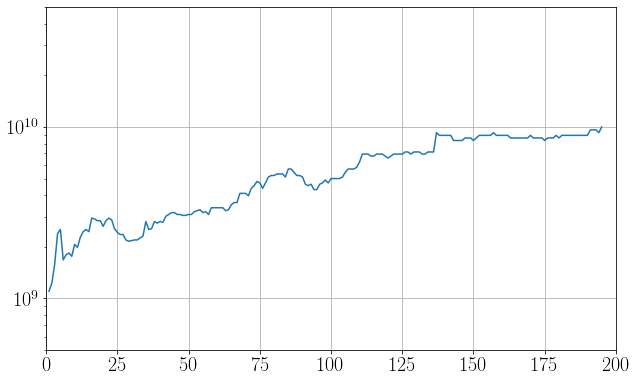

In [22]:
plt.plot(range(1,len(Mpvresult)+1),Mpvresult)
plt.yscale('log')
plt.xlim(0,200)
plt.ylim(5e8,5e10)